### <center>M2 SID - Analyse et exploitation de données</center>
# <center>Image - TP3 : Identification de visages</center>
## <center>Emma Grandgirard</center>

In [1]:
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import *
import numpy as np
import os
from scipy import linalg
from sklearn.metrics import mean_squared_error

os.chdir(os.path.join(os.getcwd(), 'Data', 'Data'))

In [2]:
# Constantes
person = ['fcmr0', 'fcrh0', 'fdac1', 'fdms0',
          'fdrd1', 'fedw0', 'felc0', 'fgjd0']
nb_pers = len(person)
rep_APP = 'APP'
rep_TEST = 'TEST'
nb_images_APP = 3
nb_images_TEST = 1
save_fig = True

## 1. Apprentissage

### 1.a Lecture des fichiers

In [4]:
# chemins vers les images APP, pour chaque personne
dir_pers_app = [os.path.join(person[k], rep_APP) for k in range(len(person))]
# chemins vers les images TEST, pour chaque personne
dir_pers_test = [os.path.join(person[k], rep_TEST) for k in range(len(person))]

In [5]:
imgs_nb = []
for k in range(len(dir_pers_app)):  # pour chaque personne
    imgs_names = os.listdir(dir_pers_app[k])  # liste des images APP de la personne
    for i in range(len(imgs_names)):  # pour chaque image
        img = imread(os.path.join(dir_pers_app[k], imgs_names[i]))
        img_ng = np.mean(img, axis=2)  # niveaux de gris
        imgs_nb.append(np.ravel(img_ng))  # on ajoute l'image niveaux de gris de la personne à la liste de toutes les images

In [6]:
# taille des images
dimL = imread(os.path.join(dir_pers_app[0], os.listdir(dir_pers_app[0])[0])).shape[0]
dimC = imread(os.path.join(dir_pers_app[0], os.listdir(dir_pers_app[0])[0])).shape[1]

### 1.b Calcul de l'image moyenne

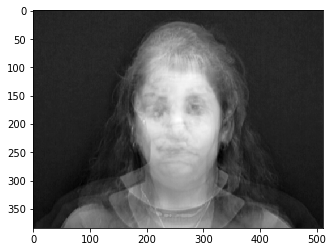

In [7]:
# images APP retenues, ici 3 par personne
imgs_app = [imgs_nb[k*10+i]
            for k in range(nb_pers) for i in range(nb_images_APP)]
avg_img = np.mean(imgs_app, axis=0)  # image moyenne
plt.imshow(avg_img.reshape(dimL, dimC), cmap='Greys_r')

In [8]:
# enregistrement de l'image moyenne
if save_fig:
    imsave('TEMP/average.png', avg_img.reshape(dimL, dimC))

### 1.c Calcul de M = image - image moyenne

In [9]:
# on soustrait l'image moyenne à chaque image
list_comp_M = [np.array(imgs_app[k] - avg_img) for k in range(len(imgs_app))]
M = np.array(list_comp_M)

### 1.d  Singular Value Decomposition

In [10]:
# décomposition en matrices singulières
res_SVD = linalg.svd(np.transpose(M), full_matrices=False)
# eigenfaces : matrice unitaire dont les vecteurs singuliers sont en colonnes
eigenfaces = res_SVD[0]

In [11]:
if save_fig:
    for i in range(eigenfaces.shape[1]):  # eigenfaces.shape[1] = nombre de colonnes = N = 24 ici
        imsave(f'TEMP//{str(i)}.png', eigenfaces[:,i].reshape(dimL, dimC))

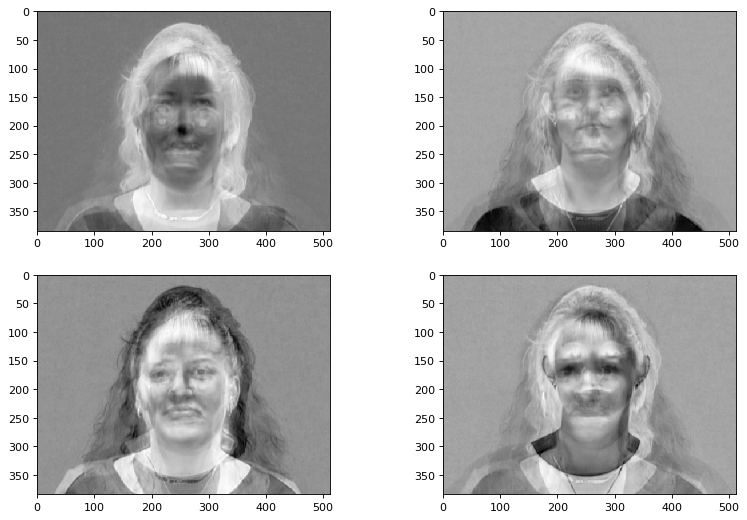

In [12]:
plt.figure(0, figsize=(12, 8), dpi=80)
c = 0
for i in range(2):
    for j in range(2):
        ax = plt.subplot2grid((2, 2), (i, j))
        plt.imshow(eigenfaces[:, c].reshape(dimL, dimC), cmap='Greys_r')
        c += 1
plt.show()

### 1.e Calcul des poids associés à chaque visage propre

In [13]:
weights = np.dot(M, eigenfaces)  # projection de M suivant les vecteurs propres
N = eigenfaces.shape[1]

In [14]:
# reconstruction de visages
# on obtient un jeu de N² (ici 576) images reconstituées
if save_fig:
    for p in range(N):
        for i in range(N):
            recon = avg_img + np.dot(weights[p, :i], eigenfaces[:, :i].T)
            img_id = f'{str(p)}_{str(i)}''
            imsave(f'TEMP{img_id}.png', recon.reshape(dimL, dimC))

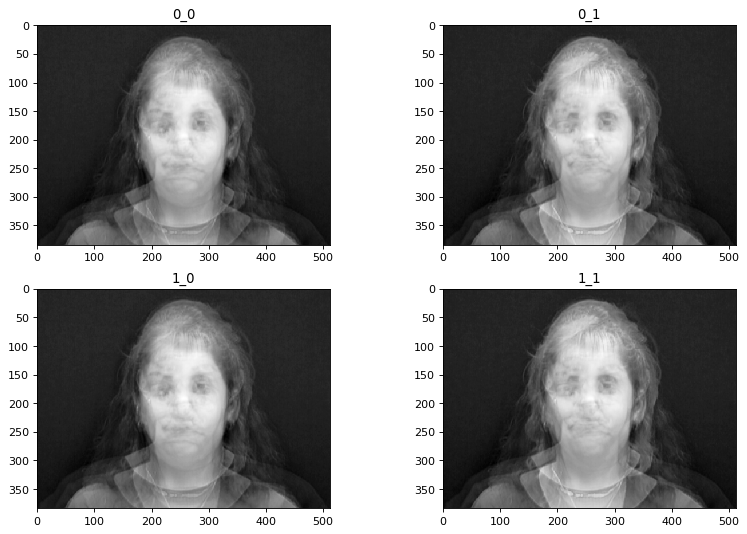

In [15]:
plt.figure(0, figsize=(12, 8), dpi=80)
for p in range(2):
    for i in range(2):
        ax = plt.subplot2grid((2, 2), (p, i))
        plt.imshow(
            (avg_img + np.dot(weights[p, :i], eigenfaces[:, :i].T)).reshape(dimL, dimC), cmap='Greys_r')
        ax.set_title(str(p)+'_'+str(i))
plt.show()

## 2. Reconnaissance

### 2.a Mise en place de la méthode d'évaluation et vérification sur le jeu d'apprentissage

In [16]:
count = 0
count_reco = 0
for x in person:
    #print('person : '+str(x))
    for i in range(1, nb_images_APP+1):
        #print('i : '+str(i))

        # Creation du nom
        if i < 10:
            file_name = os.path.join(x, 'APP', f'00{str(i)}')
        else:
            file_name = os.path.join(x, 'APP', f'0{str(i)}')

        # Lecture de l'image puis mise en vecteur
        img = imread(file_name)
        img_ng = np.mean(img, axis=2)
        img_vect = np.ravel(img_ng)

        # Soustraction de l'image moyenne
        img_norm = img_vect - avg_img

        # Calcul des poids associés à chaque visage propre
        weight = np.dot(img_norm, eigenfaces)

        # Chercher la personne la plus proche dans le nouvel espace
        EQMs = []
        for k in range(nb_pers):  # pour chaque personne
            # comparaison des poids
            EQMs.append(mean_squared_error(weights[k*nb_images_APP], weight))

        mindist = np.min(EQMs)  # plus petite EQM
        indiceImg = np.argmin(EQMs)  # indice de la personne la plus proche
        y = person[indiceImg]  # personne la plus proche

        # Affichage des résultats
        print('Personne cible --> ' + x + ' - Personne reconnue --> ' + y)
        if y == x:
            print('Personne reconnue')
            count_reco += 1
        else:
            print('Personne non reconnue')
        count += 1

print(f'Taux de reconnaissance : {str(round((count_reco/count)*100, 1))}%')

Personne cible --> fcmr0 - Personne reconnue --> fcmr0
Personne reconnue
Personne cible --> fcmr0 - Personne reconnue --> fcmr0
Personne reconnue
Personne cible --> fcmr0 - Personne reconnue --> fcmr0
Personne reconnue
Personne cible --> fcrh0 - Personne reconnue --> fcrh0
Personne reconnue
Personne cible --> fcrh0 - Personne reconnue --> fcrh0
Personne reconnue
Personne cible --> fcrh0 - Personne reconnue --> fcrh0
Personne reconnue
Personne cible --> fdac1 - Personne reconnue --> fdac1
Personne reconnue
Personne cible --> fdac1 - Personne reconnue --> fdac1
Personne reconnue
Personne cible --> fdac1 - Personne reconnue --> fdac1
Personne reconnue
Personne cible --> fdms0 - Personne reconnue --> fdms0
Personne reconnue
Personne cible --> fdms0 - Personne reconnue --> fdms0
Personne reconnue
Personne cible --> fdms0 - Personne reconnue --> fdms0
Personne reconnue
Personne cible --> fdrd1 - Personne reconnue --> fdrd1
Personne reconnue
Personne cible --> fdrd1 - Personne reconnue --> fd

### 2.b Evaluation

In [17]:
count = 0
count_reco = 0
for x in person:
    #print('person : '+str(x))
    for i in range(1, nb_images_TEST+1):
        #print('i : '+str(i))

        # Creation du nom
        if i < 10:
            file_name = os.path.join(x, 'APP', f'00{str(i)}')
        else:
            file_name = os.path.join(x, 'APP', f'0{str(i)}')

        # Lecture de l'image puis mise en vecteur
        img = imread(file_name)
        img_ng = np.mean(img, axis=2)
        img_vect = np.ravel(img_ng)

        # Soustraction de l'image moyenne
        img_norm = img_vect - avg_img

        # Calcul des poids associés à chaque visage propre
        weight = np.dot(img_norm, eigenfaces)

        # Chercher la personne la plus proche dans le nouvel espace
        EQMs = []
        for k in range(nb_pers):  # pour chaque personne
            # comparaison des poids
            EQMs.append(mean_squared_error(weights[k*nb_images_APP], weight))

        mindist = np.min(EQMs)  # plus petite EQM
        indiceImg = np.argmin(EQMs)  # indice de la personne la plus proche
        y = person[indiceImg]  # personne la plus proche

        # Affichage des résultats
        print('Personne cible --> ' + x + ' - Personne reconnue --> ' + y)
        if y == x:
            print('Personne reconnue')
            count_reco += 1
        else:
            print('Personne non reconnue')
        count += 1

print(f'Taux de reconnaissance : {str(round((count_reco/count)*100, 1))}%')

Personne cible --> fcmr0 - Personne reconnue --> fcmr0
Personne reconnue
Personne cible --> fcrh0 - Personne reconnue --> fcrh0
Personne reconnue
Personne cible --> fdac1 - Personne reconnue --> felc0
Personne non reconnue
Personne cible --> fdms0 - Personne reconnue --> fdms0
Personne reconnue
Personne cible --> fdrd1 - Personne reconnue --> fgjd0
Personne non reconnue
Personne cible --> fedw0 - Personne reconnue --> fgjd0
Personne non reconnue
Personne cible --> felc0 - Personne reconnue --> felc0
Personne reconnue
Personne cible --> fgjd0 - Personne reconnue --> fgjd0
Personne reconnue
Taux de reconnaissance : 62.5%
